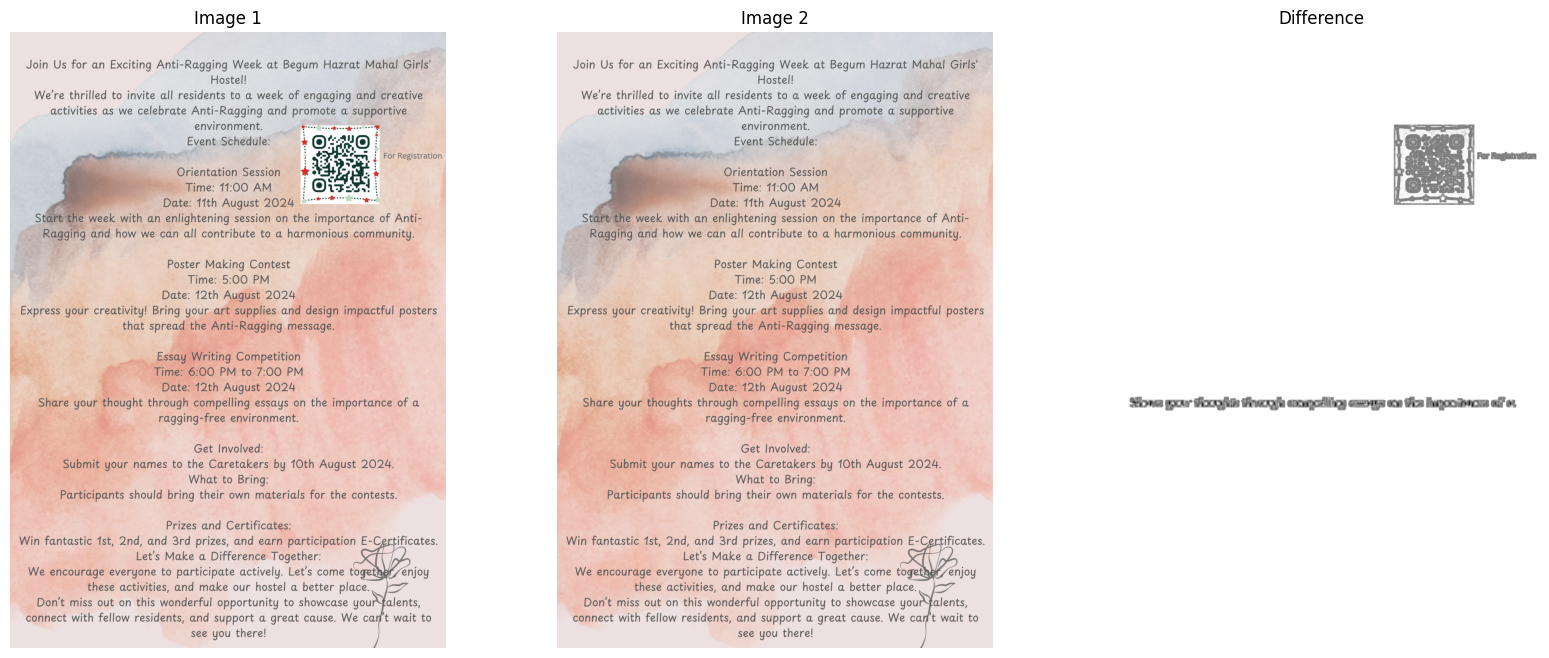

In [65]:
import os
import tempfile
import shutil
import io
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

def read_file_from_local(path):
    try:
        with open(path, 'rb') as f:
            file_contents = f.read()
        return file_contents
    except IOError as e:
        print(f"Error reading file: {e}")
        return ""

def compute_ssim(img1, img2):
    """
    Compute the Structural Similarity Index (SSIM) between two images.

    Args:
        img1 (numpy array): First image
        img2 (numpy array): Second image

    Returns:
        float: SSIM score between 0 and 1
        numpy array: Difference image
    """
    ssim_score, diff = ssim(img1, img2, full=True)
    return ssim_score, diff

def compare_images_ssim(image1_path, image2_path):
    """
    Compare two images using SSIM and return a boolean indicating whether they are identical.

    Args:
        image1_path (str): Path to the first image
        image2_path (str): Path to the second image

    Returns:
        bool: True if the images are identical, False otherwise
        numpy array: Difference image
    """
    try:
        img1_bytes = read_file_from_local(image1_path)
        img2_bytes = read_file_from_local(image2_path)

        if not img1_bytes or not img2_bytes:
            print("Error: Unable to read one or both images")
            return False, None

        img1_stream = io.BytesIO(img1_bytes)
        img2_stream = io.BytesIO(img2_bytes)

        img1 = Image.open(img1_stream)
        img2 = Image.open(img2_stream)

        # Resize images to have the same dimensions
        img1 = img1.resize(img2.size)

        img1 = np.array(img1.convert('L'))
        img2 = np.array(img2.convert('L'))

        ssim_score, diff = compute_ssim(img1, img2)

        return ssim_score >= 0.99, diff  # adjust the threshold as needed
    except Exception as e:
        print(f"Error comparing images: {e}")
        return False, None

def show_images(image1_path, image2_path):
    identical, diff = compare_images_ssim(image1_path, image2_path)
    
    if diff is not None:
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))
        ax = axes.ravel()

        img1 = Image.open(image1_path)
        img2 = Image.open(image2_path)

        ax[0].imshow(img1, cmap=plt.cm.gray)
        ax[0].set_title('Image 1')

        ax[1].imshow(img2, cmap=plt.cm.gray)
        ax[1].set_title('Image 2')

        ax[2].imshow(diff, cmap=plt.cm.gray)
        ax[2].set_title('Difference')

        for a in ax:
            a.axis('off')

        plt.show()
    else:
        print("Could not compute the difference image.")

# Example usage for comparing images and showing differences
image1_path = "resource/Make a difference (1).png"
image2_path = "resource/sdadsda.png"

show_images(image1_path, image2_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


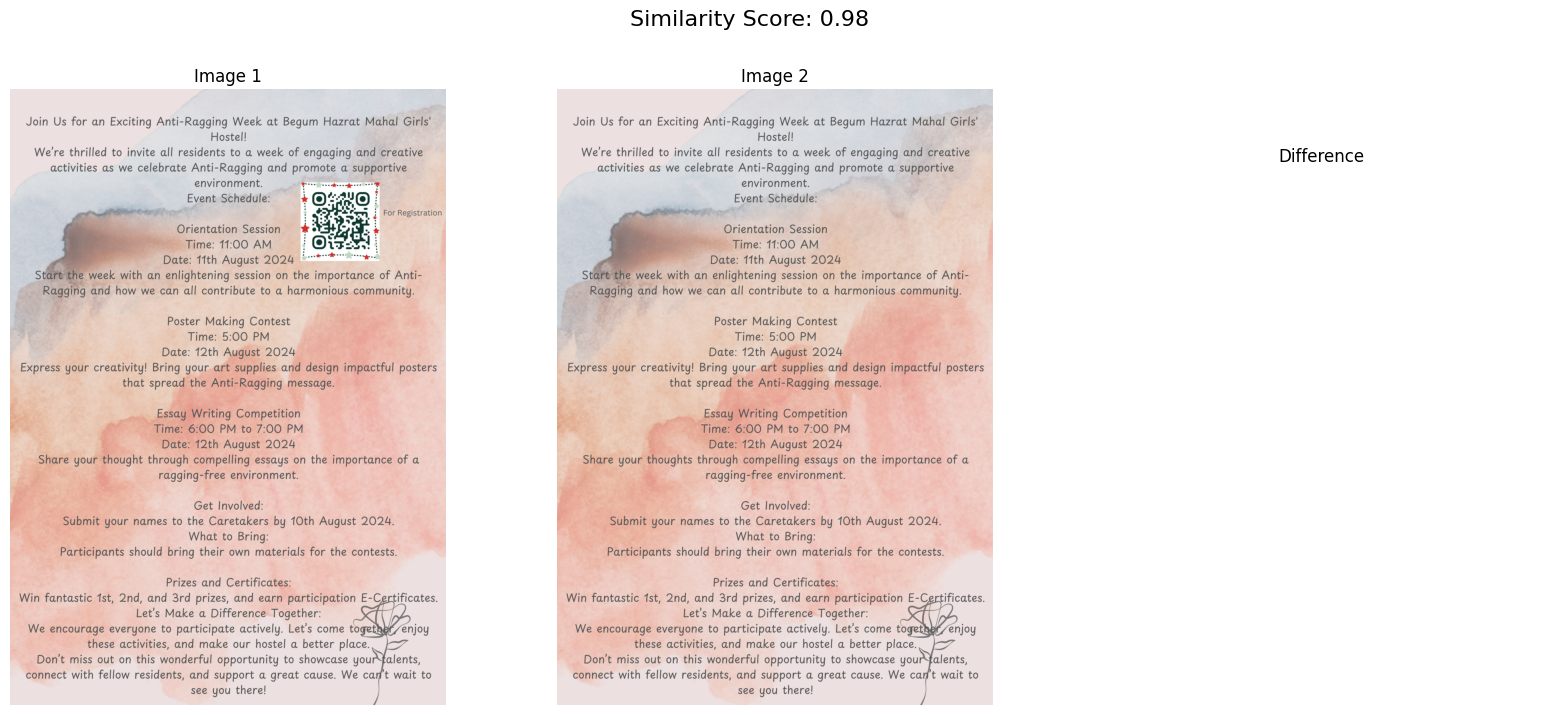

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity

# Load the VGG16 model pre-trained on ImageNet
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

def read_and_preprocess_image(img_path):
    """
    Read and preprocess an image for VGG16 model.

    Args:
        img_path (str): Path to the image file

    Returns:
        numpy array: Preprocessed image
    """
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def extract_features(img_path):
    """
    Extract features from an image using VGG16 model.

    Args:
        img_path (str): Path to the image file

    Returns:
        numpy array: Feature vector
    """
    img_array = read_and_preprocess_image(img_path)
    features = model.predict(img_array)
    return features

def compare_images_dense_vectors(image1_path, image2_path):
    """
    Compare two images using Dense Vector Representations and return the similarity score.

    Args:
        image1_path (str): Path to the first image
        image2_path (str): Path to the second image

    Returns:
        float: Similarity score between 0 and 1
    """
    features1 = extract_features(image1_path)
    features2 = extract_features(image2_path)

    similarity = cosine_similarity(features1, features2)
    return similarity[0][0]

def show_images(image1_path, image2_path):
    similarity = compare_images_dense_vectors(image1_path, image2_path)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    ax = axes.ravel()

    img1 = Image.open(image1_path)
    img2 = Image.open(image2_path)

    # Convert images to numpy arrays for subtraction
    img1_array = np.array(img1.resize((224, 224)))
    img2_array = np.array(img2.resize((224, 224)))

    # Calculate the absolute difference between the images
    diff = np.abs(img1_array - img2_array)

    ax[0].imshow(img1)
    ax[0].set_title('Image 1')

    ax[1].imshow(img2)
    ax[1].set_title('Image 2')

    ax[2].imshow(diff)
    ax[2].set_title('Difference')

    for a in ax:
        a.axis('off')

    plt.suptitle(f'Similarity Score: {similarity:.2f}', fontsize=16)
    plt.show()

# Example usage for comparing images and showing differences
image1_path = r"C:\Users\acer\Desktop\python_image_comparison\resources\Make a difference (1).png"
image2_path = r"C:\Users\acer\Desktop\python_image_comparison\resources\sdadsda.png"

show_images(image1_path, image2_path)

In [14]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/10.9 MB 4.8 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/10.9 MB 5.3 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/10.9 MB 5.6 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/10.9 MB 6.1 MB/s eta 0:00:02
   --------------------- ------------------ 5.8/10.9 MB 5.8 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/10.9 MB 5.8 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/10.9 MB 5.7 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/10.9 MB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 10.9/10.9 MB 5.9 MB/s eta 0:00:00
